In [91]:
import networks.network_regression as net
import os
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import copy

root_path = './result_data/bests/'

In [92]:
shot = 5
device = 'cpu'
exp_paths = [f'maml_sin_{shot}shot', f'fomaml_sin_{shot}shot', f'reptile_sin_{shot}shot']
model_paths = [os.path.join(root_path, exp_path, 'best_model.pt') for exp_path in exp_paths]

In [93]:
models = [net.mlp(1, 1) for _ in range(len(exp_paths))]
for model, model_path in zip(models, model_paths):
    ckpt = torch.load(model_path)
    model.load_state_dict(ckpt)

In [94]:
from data_handler.SineNShot import SineNShot
dataloader = SineNShot(batchsz=1, k_shot=shot, k_query=10)
x_spt, y_spt, x_qry, y_qry = dataloader.next('test')


In [95]:
class Sine(object):
    def __init__(self, amplitude, phase):
        self.amplitude = amplitude
        self.phase = phase
    
    def generate(self, x):
        return np.sin(x + self.phase) * self.amplitude

In [103]:
amplitude = np.random.uniform(0.1, 5)
phase = np.random.uniform(0, np.pi)
sin_func = Sine(amplitude, phase)

In [104]:
batchsz = 1
setsz = shot
querysz = 10

x_spts, y_spts, x_qrys, y_qrys = [], [], [], []
for i in range(batchsz):  # one batch means one set
    x_spt, y_spt, x_qry, y_qry = [], [], [], []

    x_spt = np.random.rand(setsz) * 10 - 5
    x_qry = np.random.rand(querysz) * 10 - 5
    y_spt = sin_func.generate(x_spt)
    y_qry = sin_func.generate(x_qry)

    # append [sptsz, 1] => [b, setsz, 1]
    x_spts.append(x_spt)
    y_spts.append(y_spt)
    x_qrys.append(x_qry)
    y_qrys.append(y_qry)

# [b, setsz, 1]
x_spts = np.array(x_spts).astype(np.float32).reshape(batchsz, setsz, 1)
y_spts = np.array(y_spts).astype(np.float32).reshape(batchsz, setsz, 1)
# [b, qrysz]
x_qrys = np.array(x_qrys).astype(np.float32).reshape(batchsz, querysz, 1)
y_qrys = np.array(y_qrys).astype(np.float32).reshape(batchsz, querysz, 1)

In [105]:
x_spt, y_spt, x_qry, y_qry = x_spts[0], y_spts[0], x_qrys[0], y_qrys[0]
x_spt, y_spt, x_qry, y_qry = torch.from_numpy(x_spt).to(device), torch.from_numpy(y_spt).to(device), torch.from_numpy(x_qry).to(device), torch.from_numpy(y_qry).to(device)
x_spt.size()

torch.Size([5, 1])

In [99]:
def model_functions_at_training(initial_model, X, y, sampled_steps, x_axis, optim=torch.optim.SGD, lr=0.01):
    """
    trains the model on X, y and measures the loss curve.
    
    for each n in sampled_steps, records model(x_axis) after n gradient updates.
    """
    
    # copy MAML model into a new object to preserve MAML weights during training
    model = copy.deepcopy(initial_model)
    criterion = nn.MSELoss()
    optimiser = optim(model.parameters(), lr)

    # train model on a random task
    num_steps = max(sampled_steps)
    K = X.shape[0]
    
    losses = []
    outputs = {}
    for step in range(1, num_steps + 1):
        loss = criterion(model(X), y) / K
        losses.append(loss.item())

        # compute grad and update inner loop weights
        model.zero_grad()
        loss.backward()
        optimiser.step()

        # plot the model function
        if step in sampled_steps:
            outputs[step] = model(torch.tensor(x_axis, dtype=torch.float).view(-1, 1)).detach().numpy()
            
    outputs['initial'] = initial_model(torch.tensor(x_axis, dtype=torch.float).view(-1, 1)).detach().numpy()
    
    return outputs, losses

In [127]:
def plot_sampled_performance(initial_model, model_name, X, y, optim=torch.optim.SGD, lr=0.01):
    
    x_axis = np.linspace(-5, 5, 1000)
    sampled_steps=[1,10]
    outputs, losses = model_functions_at_training(initial_model, 
                                                  X, y, 
                                                  sampled_steps=sampled_steps, 
                                                  x_axis=x_axis, 
                                                  optim=optim, lr=lr)

    plt.figure(figsize=(15,5))
    
    # plot the model functions
    plt.subplot(1, 2, 1)
    
    plt.plot(x_axis, sin_func.generate(x_axis), '-', color=(0, 0, 1, 0.5), label='true function')
    plt.scatter(X, y, label='data')
    plt.plot(x_axis, outputs['initial'], ':', color=(0.7, 0, 0, 1), label='initial weights')
    
    for step in sampled_steps:
        plt.plot(x_axis, outputs[step], 
                 '-.' if step == 1 else '-', color=(0.5, 0, 0, 1),
                 label='model after {} steps'.format(step))
        
    plt.legend(loc='lower right')
    plt.title("Model fit: {}".format(model_name))

    # plot losses
    plt.subplot(1, 2, 2)
    plt.plot(losses)
    plt.title("Loss over time")
    plt.xlabel("gradient steps taken")
    plt.show()

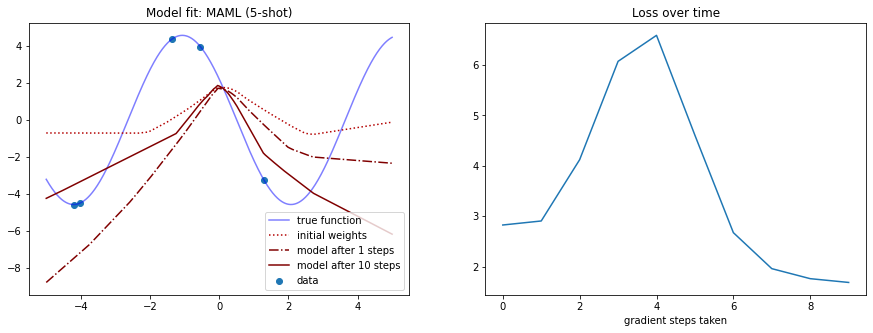

In [131]:
plot_sampled_performance(models[0], f'MAML ({shot}-shot)', x_spt, y_spt)

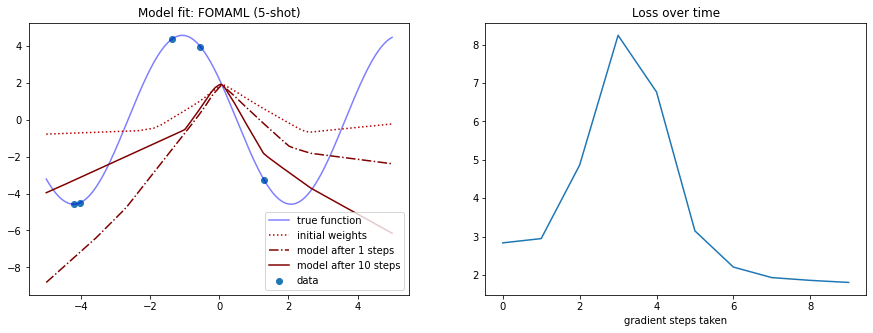

In [132]:
plot_sampled_performance(models[1], f'FOMAML ({shot}-shot)', x_spt, y_spt)

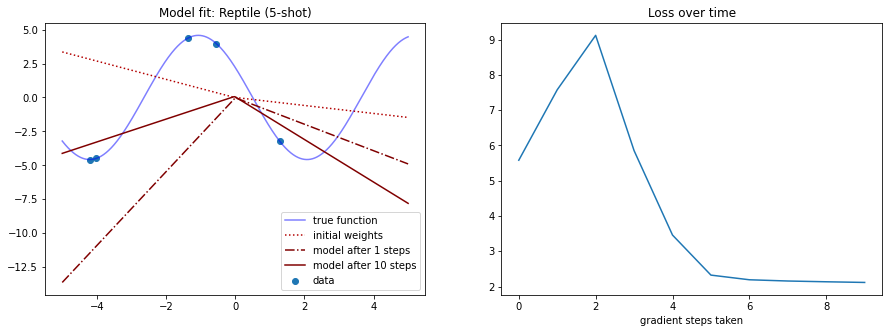

In [133]:
plot_sampled_performance(models[2], f'Reptile ({shot}-shot)', x_spt, y_spt)